In [6]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [7]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale = 0.01):

    params = []
    keys = jax.random.split(parent_key, num = len(layer_widths) - 1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape = (out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape = (out_width,))
                       ]
        )
    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [8]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits) # Log softmax

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [9]:
def custom_transform(x):
    # Transform image to numpy data type from pillow data typess
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int32


In [10]:
"""num_epochs = 20

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)


# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for counter, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if counter % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')
    """ 
# jax.tree_multimap deprecated


"num_epochs = 20\n\ndef loss_fn(params, imgs, gt_lbls):\n    predictions = batched_MLP_predict(params, imgs)\n\n    return -jnp.mean(predictions * gt_lbls)\n\ndef accuracy(params, dataset_imgs, dataset_lbls):\n    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)\n    return jnp.mean(dataset_lbls == pred_classes)\n\n@jit\ndef update(params, imgs, gt_lbls, lr=0.01):\n    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)\n\n    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)\n\n\n# Create a MLP\nMLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)\n\nfor epoch in range(num_epochs):\n\n    for counter, (imgs, lbls) in enumerate(train_loader):\n\n        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))\n        \n        loss, MLP_params = update(MLP_params, imgs, gt_labels)\n        \n        if counter % 50 == 0:\n            print(loss)\n\n    print(f'Epoch {epoch}, train acc = {accuracy(MLP_pa

(28, 28)
pred 1
gt 7


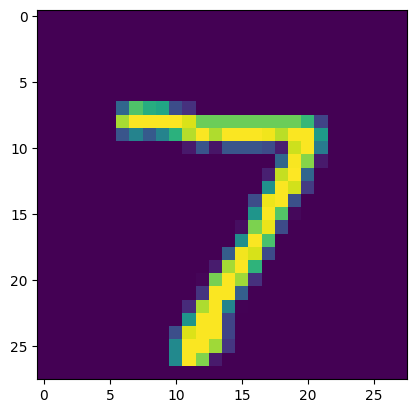

In [11]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

(512, 784)
(28, 28)


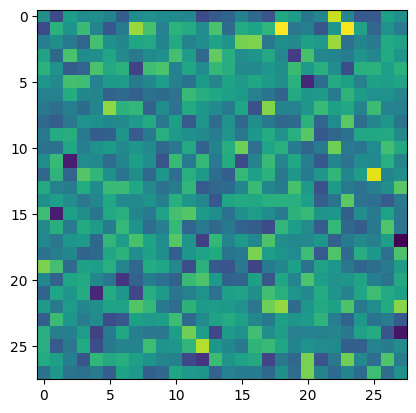

In [12]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[32, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()